In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

results = pd.read_parquet("./sampling_scaling_rtt.gzip")

# only look at the empirical-high timing model (ground truth)
# results = results[results["timing_model"] == "empirical-high"].copy()
results["timing_model"] = results["timing_model"].cat.remove_unused_categories()


def _classify_sampling(s: str) -> str:
    ssplit = s.split("-")
    if len(ssplit) > 1:
        if ssplit[0] == "adaptive":
            if ssplit[1] == "power":
                return "adaptive-energy"
            elif ssplit[1] == "hold":
                return "adaptive-hold"
            else:
                return "adaptive-ttf"
        return ssplit[0]
    else:
        return "reference"


results["sampling_class"] = (
    results["sampling_scheme"]
    .apply(_classify_sampling)
    .astype(pd.CategoricalDtype(["adaptive-energy", "adaptive-hold", "adaptive-ttf", "reference", "periodic", "hold"]))
)

included_schemes = (
['greedy',
 'ideal',
 'adaptive-power-rolling-ttf',
 'adaptive-power-rolling-ttf-low',
 'adaptive-power-rolling-ttf-high',
 'adaptive-power-fitted-rolling-ttf-exgaussian',
 'adaptive-power-fitted-rolling-ttf-exgaussian-low',
 'adaptive-power-fitted-rolling-ttf-exgaussian-high',
 'adaptive-power-fitted-naive-exgaussian',
 'adaptive-hold-rolling-ttf-high',
 'adaptive-hold-rolling-ttf-low',
 'adaptive-hold-fitted-rolling-ttf-exgaussian-high',
 'adaptive-hold-fitted-rolling-ttf-exgaussian-low',
 'adaptive-hold-fitted-naive-exgaussian']
)

results = results[np.isin(results["sampling_scheme"], included_schemes)]
results["sampling_scheme"] = results["sampling_scheme"].astype(pd.CategoricalDtype(included_schemes, ordered=True))
results["success_sample_instant"] = results["execution_time"] + results["wait_time"]

results

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,...,energy,cumulative_energy,comm_time,idle_time,comm_energy,idle_energy,timing_model,sampling_scheme,sampling_class,success_sample_instant
0,2.5,1,2.500000,5.023795,8.343657,3.319862,0.819862,1,8.343657,1,...,0.191155,0.191155,2.2,6.143657,0.0990,0.092155,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,5.843657
1,2.5,2,3.319862,7.106898,10.843657,3.736759,1.236759,2,19.187314,3,...,0.294655,0.485810,4.4,6.443657,0.1980,0.096655,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,8.343657
2,2.5,3,3.736759,7.182008,10.843657,3.661649,1.161649,2,30.030971,5,...,0.294655,0.780465,4.4,6.443657,0.1980,0.096655,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,8.343657
3,2.5,4,3.661649,5.542222,8.343657,2.801435,0.301435,1,38.374629,6,...,0.191155,0.971619,2.2,6.143657,0.0990,0.092155,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,5.843657
4,2.5,5,2.801435,6.528075,10.843657,4.315582,1.815582,2,49.218286,8,...,0.294655,1.266274,4.4,6.443657,0.1980,0.096655,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,8.343657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007995,4.0,116,4.000000,3.684599,7.684599,4.000000,0.000000,1,1114.875916,116,...,0.226269,29.599139,3.7,3.984599,0.1665,0.059769,rolling-ttf-high,ideal,reference,3.684599
1007996,4.0,117,4.000000,7.097912,11.097912,4.000000,0.000000,1,1125.973829,117,...,0.277469,29.876607,3.7,7.397912,0.1665,0.110969,rolling-ttf-high,ideal,reference,7.097912
1007997,4.0,118,4.000000,4.841299,8.841299,4.000000,0.000000,1,1134.815127,118,...,0.243619,30.120227,3.7,5.141299,0.1665,0.077119,rolling-ttf-high,ideal,reference,4.841299
1007998,4.0,119,4.000000,5.434020,9.434020,4.000000,0.000000,1,1144.249148,119,...,0.252510,30.372737,3.7,5.734020,0.1665,0.086010,rolling-ttf-high,ideal,reference,5.434020


In [8]:
power_consts = {
    # "comm": 0.045,
    "comm": 0.045,
    "idle": 0.015
}  # Watts

mean_power = (
    results.groupby(["sampling_class", "sampling_scheme", "rtt", "repetition"], observed=True)
    [["samples", "idle_time", "comm_time", "step_duration"]]
    .sum()
    .reset_index()
    .copy()
)
mean_power["comm_time"] = mean_power["samples"] * (mean_power["rtt"] - 0.3)
mean_power["comm_energy"] = mean_power["comm_time"] * power_consts["comm"]
mean_power["idle_time"] = mean_power["step_duration"] - mean_power["comm_time"]
mean_power["idle_energy"] = mean_power["idle_time"] * power_consts["idle"]

mean_power["total_energy"] = mean_power["idle_energy"] + mean_power["comm_energy"]
mean_power["power"] = mean_power["total_energy"] / mean_power["step_duration"]
mean_power

,sampling_class,sampling_scheme,rtt,repetition,samples,idle_time,comm_time,step_duration,comm_energy,idle_energy,total_energy,power
0,adaptive-hold,adaptive-hold-rolling-ttf-high,0.5,1,430,826.436295,86.0,912.436295,3.870,12.396544,16.266544,0.017828
1,adaptive-hold,adaptive-hold-rolling-ttf-high,0.5,2,311,791.284013,62.2,853.484013,2.799,11.869260,14.668260,0.017186
2,adaptive-hold,adaptive-hold-rolling-ttf-high,0.5,3,533,855.881541,106.6,962.481541,4.797,12.838223,17.635223,0.018323
3,adaptive-hold,adaptive-hold-rolling-ttf-high,0.5,4,413,823.267052,82.6,905.867052,3.717,12.349006,16.066006,0.017736
4,adaptive-hold,adaptive-hold-rolling-ttf-high,0.5,5,354,804.134456,70.8,874.934456,3.186,12.062017,15.248017,0.017428
...,...,...,...,...,...,...,...,...,...,...,...,...
8395,reference,ideal,5.0,56,120,900.267124,564.0,1464.267124,25.380,13.504007,38.884007,0.026555
8396,reference,ideal,5.0,57,120,805.075657,564.0,1369.075657,25.380,12.076135,37.456135,0.027359
8397,reference,ideal,5.0,58,120,855.883586,564.0,1419.883586,25.380,12.838254,38.218254,0.026916
8398,reference,ideal,5.0,59,120,899.874983,564.0,1463.874983,25.380,13.498125,38.878125,0.026558


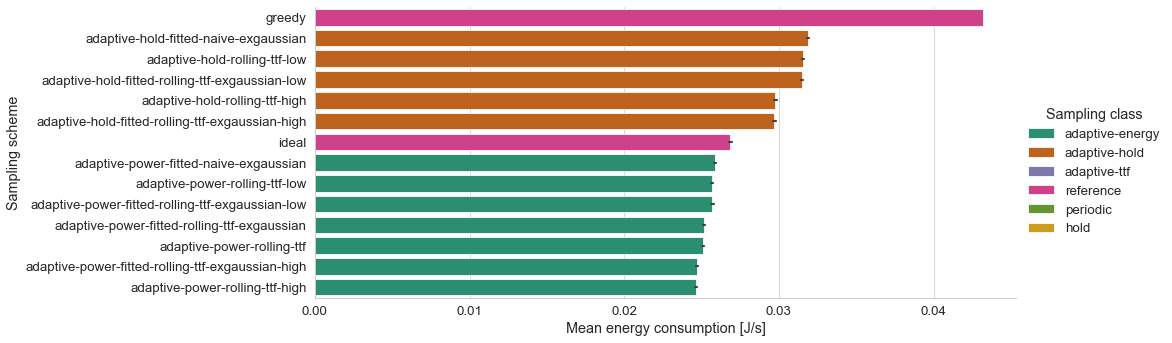

count  \
sampling_class  sampling_scheme                                            
reference       greedy                                              60.0   
adaptive-hold   adaptive-hold-fitted-naive-exgaussian               60.0   
                adaptive-hold-rolling-ttf-low                       60.0   
                adaptive-hold-fitted-rolling-ttf-exgaussian-low     60.0   
                adaptive-hold-rolling-ttf-high                      60.0   
                adaptive-hold-fitted-rolling-ttf-exgaussian-high    60.0   
reference       ideal                                               60.0   
adaptive-energy adaptive-power-fitted-naive-exgaussian              60.0   
                adaptive-power-rolling-ttf-low                      60.0   
                adaptive-power-fitted-rolling-ttf-exgaussian-low    60.0   
                adaptive-power-fitted-rolling-ttf-exgaussian        60.0   
                adaptive-power-rolling-ttf                          60.0   
                adaptive-power-fitted-rolling-ttf-exgaussian-high   60.0   
                adaptive-power-rolling-ttf-high                     60.0   

                                                                       mean  \
sampling_class  sampling_scheme                                               
reference       greedy                                             0.043200   
adaptive-hold   adaptive-hold-fitted-naive-exgaussian              0.031892   
                adaptive-hold-rolling-ttf-low                      0.031575   
                adaptive-hold-fitted-rolling-ttf-exgaussian-low    0.031506   
                adaptive-hold-rolling-ttf-high                     0.029759   
                adaptive-hold-fitted-rolling-ttf-exgaussian-high   0.029708   
reference       ideal                                              0.026847   
adaptive-energy adaptive-power-fitted-naive-exgaussian             0.025889   
                adaptive-power-rolling-ttf-low                     0.025687   
                adaptive-power-fitted-rolling-ttf-exgaussian-low   0.025681   
                adaptive-power-fitted-rolling-ttf-exgaussian       0.025168   
                adaptive-power-rolling-ttf                         0.025103   
                adaptive-power-fitted-rolling-ttf-exgaussian-high  0.024704   
                adaptive-power-rolling-ttf-high                    0.024643   

                                                                            std  \
sampling_class  sampling_scheme                                                   
reference       greedy                                             1.131916e-17   
adaptive-hold   adaptive-hold-fitted-naive-exgaussian              3.239464e-04   
                adaptive-hold-rolling-ttf-low                      3.175678e-04   
                adaptive-hold-fitted-rolling-ttf-exgaussian-low    2.958906e-04   
                adaptive-hold-rolling-ttf-high                     3.452229e-04   
                adaptive-hold-fitted-rolling-ttf-exgaussian-high   3.271814e-04   
reference       ideal                                              3.938073e-04   
adaptive-energy adaptive-power-fitted-naive-exgaussian             2.890436e-04   
                adaptive-power-rolling-ttf-low                     2.939049e-04   
                adaptive-power-fitted-rolling-ttf-exgaussian-low   3.692173e-04   
                adaptive-power-fitted-rolling-ttf-exgaussian       3.062334e-04   
                adaptive-power-rolling-ttf                         3.359462e-04   
                adaptive-power-fitted-rolling-ttf-exgaussian-high  2.836735e-04   
                adaptive-power-rolling-ttf-high                    2.713483e-04   

                                                                        min  \
sampling_class  sampling_scheme                                               
reference       greedy                                             0.043200   
adaptive-hold   ada

In [9]:
power_max_rtt = mean_power[mean_power["rtt"] == mean_power["rtt"].max()]
mean_power_max_rtt = (
    power_max_rtt
    .groupby(["sampling_class", "sampling_scheme"], observed=True)
    ["power"]
    .describe()
    .sort_values("mean", ascending=False)
)

fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=power_max_rtt,
    x="power",
    y="sampling_scheme",
    order=mean_power_max_rtt.index.get_level_values(1),
    hue="sampling_class",
    aspect=3,
    dodge=False,
)
fg.set_axis_labels("Mean energy consumption [J/s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

mean_power_max_rtt

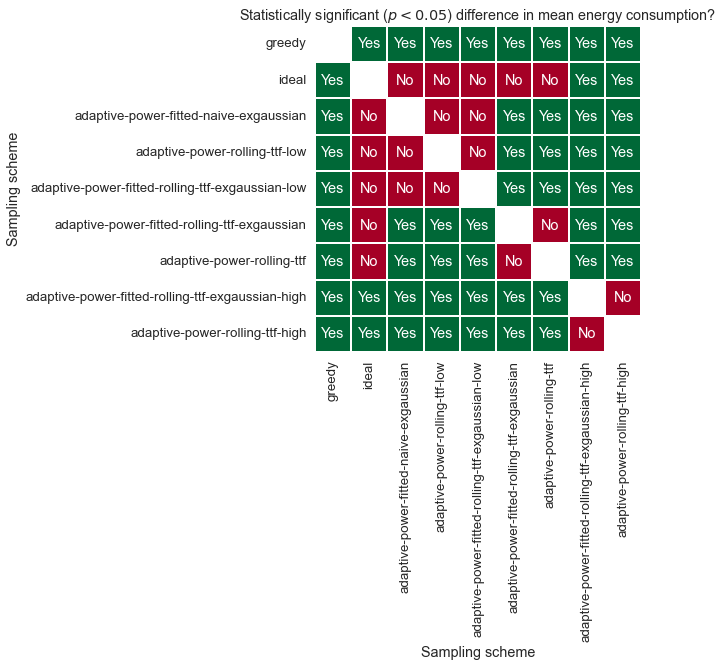

In [10]:
import scipy.stats as stats
import itertools as it

relevant_schemes = mean_power_max_rtt.loc[["reference", "adaptive-energy"], :].sort_values("mean", ascending=False).index.get_level_values(1)

p_values = pd.DataFrame(index=relevant_schemes, columns=relevant_schemes, dtype=float)
for row, col in it.product(p_values.index, p_values.columns):
    if row == col:
        continue
    t_stat, p_val = stats.ttest_ind(
        mean_power.loc[mean_power["sampling_scheme"] == row, "power"].to_numpy(),
        mean_power.loc[mean_power["sampling_scheme"] == col, "power"].to_numpy(),
        alternative="two-sided",
        # null-hypothesis is that energies have the same mean and that the observed difference is just random
    )
    p_values.at[row, col] = p_val

significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(
    significant,
    square=True,
    annot=significant.applymap(lambda e: "Yes" if e > 0.5 else "No"),
    fmt="",
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
    linewidths=2,
    ax=ax,
)
ax.set_title("Statistically significant ($p < 0.05$) difference in mean energy consumption?")
ax.set_xlabel("Sampling scheme")
ax.set_ylabel("Sampling scheme")
plt.show()

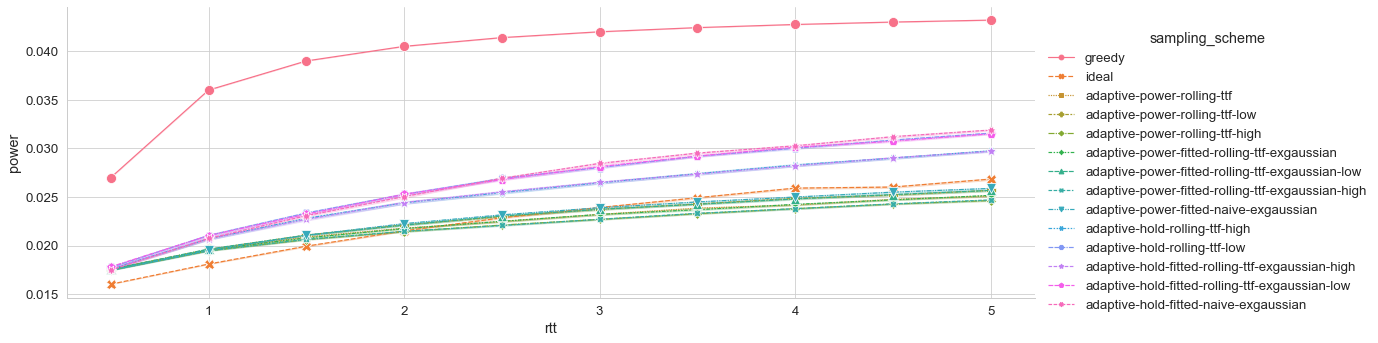

In [11]:
fg = sns.relplot(
    kind="line",
    data=mean_power,
    x="rtt",
    y="power",
    style="sampling_scheme",
    hue="sampling_scheme",
    markers=True,
    aspect=3,
    markersize=10,
)
plt.show()

In [12]:
results_per_rep = (
    results
    .groupby(["timing_model", "sampling_scheme", "sampling_class", "rtt", "repetition"], observed=True)
    [["execution_time", "step_duration", "ttf", "wait_time", "samples", "energy", "idle_energy", "comm_energy", "idle_time", "comm_time", "success_sample_instant"]]
    .mean()
    .reset_index()
)
results_per_rep

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
0,rolling-ttf-high,greedy,reference,0.5,1,5.703828,6.437500,0.733672,0.233672,12.875000,0.173812,0.057937,0.115875,3.862500,2.575000,5.937500
1,rolling-ttf-high,greedy,reference,0.5,2,5.460068,6.216667,0.756599,0.256599,12.433333,0.167850,0.055950,0.111900,3.730000,2.486667,5.716667
2,rolling-ttf-high,greedy,reference,0.5,3,5.341657,6.083333,0.741676,0.241676,12.166667,0.164250,0.054750,0.109500,3.650000,2.433333,5.583333
3,rolling-ttf-high,greedy,reference,0.5,4,4.946848,5.683333,0.736486,0.236486,11.366667,0.153450,0.051150,0.102300,3.410000,2.273333,5.183333
4,rolling-ttf-high,greedy,reference,0.5,5,5.527061,6.270833,0.743772,0.243772,12.541667,0.169313,0.056437,0.112875,3.762500,2.508333,5.770833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,5.0,56,6.930046,14.426990,7.496944,2.496944,1.716667,0.458455,0.095380,0.363075,6.358657,8.068333,9.426990
8396,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,5.0,57,6.932181,14.385324,7.453143,2.453143,1.708333,0.456655,0.095342,0.361313,6.356157,8.029167,9.385324
8397,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,5.0,58,6.772060,14.301990,7.529930,2.529930,1.691667,0.453055,0.095267,0.357787,6.351157,7.950833,9.301990
8398,rolling-ttf-high,adaptive-hold-fitted-naive-exgaussian,adaptive-hold,5.0,59,6.613346,14.135324,7.521978,2.521978,1.658333,0.445855,0.095117,0.350737,6.341157,7.794167,9.135324


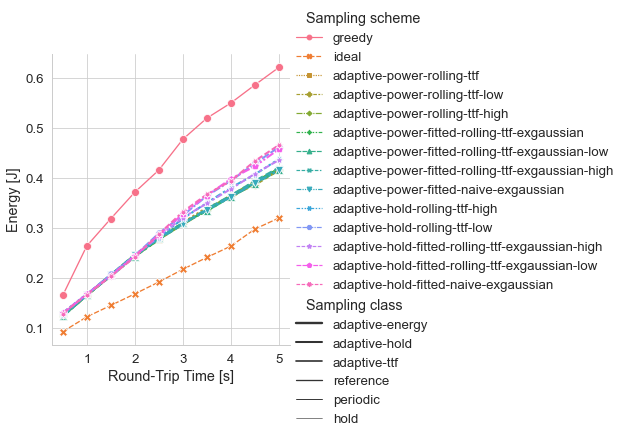

In [13]:
fg = sns.relplot(
    kind="line",
    errorbar=None,
    data=results_per_rep.rename(columns={"sampling_scheme": "Sampling scheme", "sampling_class": "Sampling class"}),
    x="rtt",
    y="energy",
    hue="Sampling scheme",
    style="Sampling scheme",
    size="Sampling class",
    markers=True,
    aspect=1,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Energy [J]")
# fg.legend.set_title("Sampling Scheme")
plt.show()

In [14]:
energy_at_max_rtt = (
    results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
    .groupby("sampling_scheme")
    ["energy"]
    .mean()
    .sort_values()
)
energy_at_max_rtt

sampling_scheme
ideal                                                0.319726
adaptive-power-fitted-rolling-ttf-exgaussian-low     0.415190
adaptive-power-rolling-ttf-low                       0.415229
adaptive-power-fitted-naive-exgaussian               0.415432
adaptive-power-rolling-ttf                           0.415619
adaptive-power-rolling-ttf-high                      0.416813
adaptive-power-fitted-rolling-ttf-exgaussian         0.418225
adaptive-power-fitted-rolling-ttf-exgaussian-high    0.419928
adaptive-hold-fitted-rolling-ttf-exgaussian-high     0.435268
adaptive-hold-rolling-ttf-high                       0.437302
adaptive-hold-fitted-rolling-ttf-exgaussian-low      0.456978
adaptive-hold-rolling-ttf-low                        0.461101
adaptive-hold-fitted-naive-exgaussian                0.465265
greedy                                               0.620160
Name: energy, dtype: float64

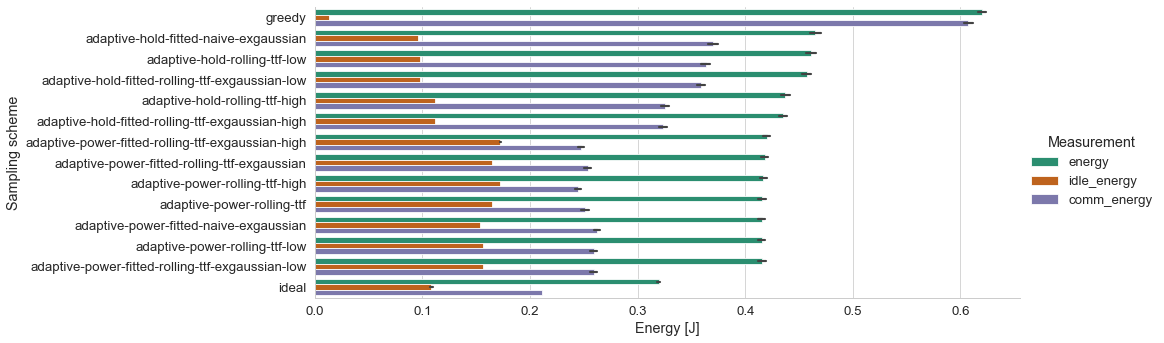

In [15]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=(
        results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
        [["sampling_scheme", "energy", "idle_energy", "comm_energy"]]
        .set_index("sampling_scheme")
        .stack()
        .reset_index()
        .rename(columns={"level_1": "energy", 0: "value"})
    ),
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="value",
    # join=False,
    hue="energy",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=True,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Measurement")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('+').  Matplotlib is ignoring

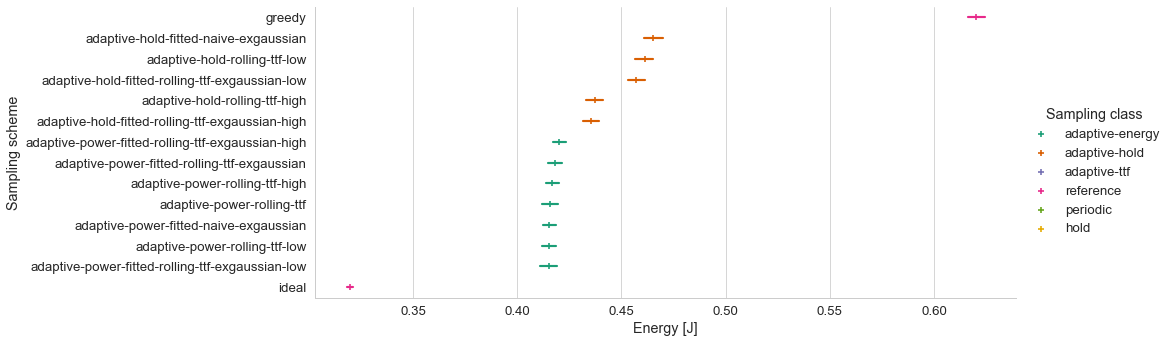

In [16]:
fg = sns.catplot(
    kind="point",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="energy",
    join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    markers="+",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

test if difference between mean energies at max rtt is statistically significant!
null hypothesis is that all sampling schemes have the same mean

In [17]:
import scipy.stats as stats

# import itertools as it

energies = (
    results_per_rep
    .loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())]
    .copy()
)

p_values = pd.DataFrame(index=included_schemes, columns=included_schemes, dtype=float)
cols = set(included_schemes)
last_row = len(included_schemes)
for row in included_schemes:
    for col in cols:
        if row == col:
            continue
        t_stat, p_val = stats.ttest_ind(
            energies.loc[energies["sampling_scheme"] == row, "energy"].to_numpy(),
            energies.loc[energies["sampling_scheme"] == col, "energy"].to_numpy(),
            alternative="two-sided",
            # null-hypothesis is that energies have the same mean and that the observed difference is just random
        )
        p_values.at[row, col] = p_val

    # cols.remove(row)
p_values.style.format(lambda e: "p < 0.05" if e < 0.05 else "Not significant")

,greedy,ideal,adaptive-power-rolling-ttf,adaptive-power-rolling-ttf-low,adaptive-power-rolling-ttf-high,adaptive-power-fitted-rolling-ttf-exgaussian,adaptive-power-fitted-rolling-ttf-exgaussian-low,adaptive-power-fitted-rolling-ttf-exgaussian-high,adaptive-power-fitted-naive-exgaussian,adaptive-hold-rolling-ttf-high,adaptive-hold-rolling-ttf-low,adaptive-hold-fitted-rolling-ttf-exgaussian-high,adaptive-hold-fitted-rolling-ttf-exgaussian-low,adaptive-hold-fitted-naive-exgaussian
greedy,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
ideal,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-rolling-ttf,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-rolling-ttf-low,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-rolling-ttf-high,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-fitted-rolling-ttf-exgaussian,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-fitted-rolling-ttf-exgaussian-low,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-fitted-rolling-ttf-exgaussian-high,p < 0.05,p < 0.05,Not significant,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-fitted-naive-exgaussian,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-hold-rolling-ttf-high,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05


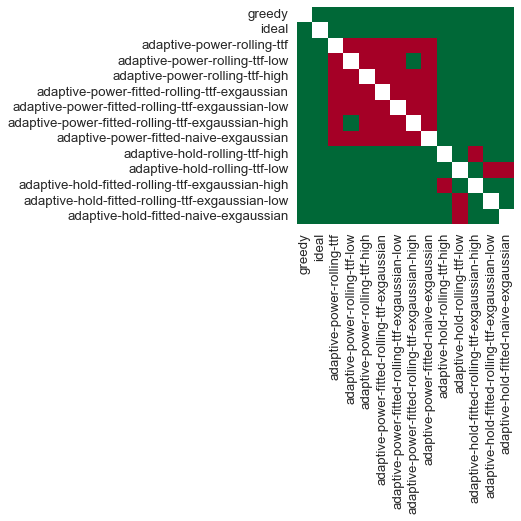

In [18]:
significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

ax = sns.heatmap(
    significant,
    square=True,
    # annot=True,
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
)
plt.show()


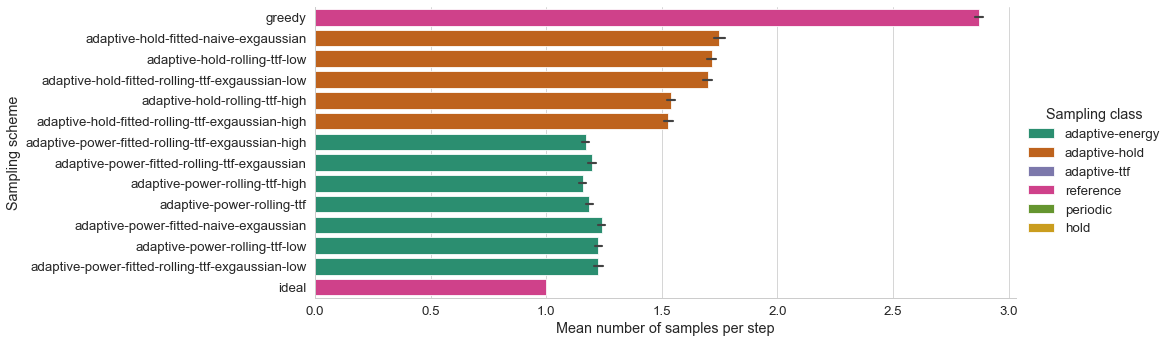

In [19]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="samples",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean number of samples per step", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

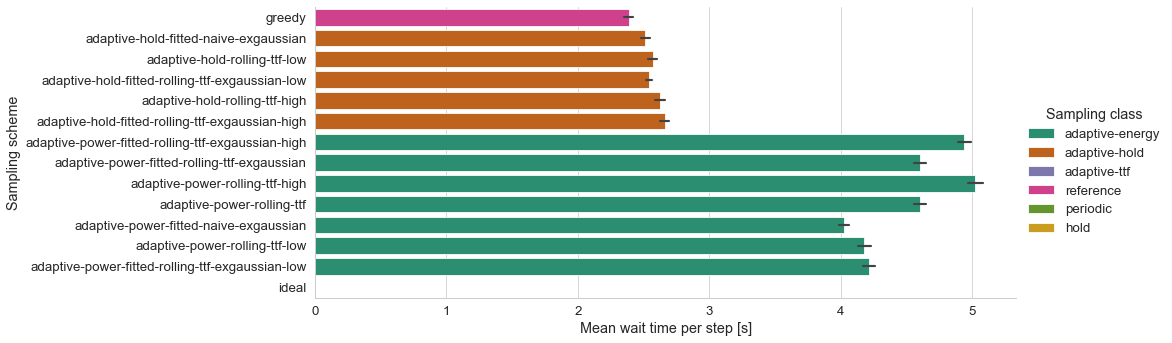

In [20]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="wait_time",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean wait time per step [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

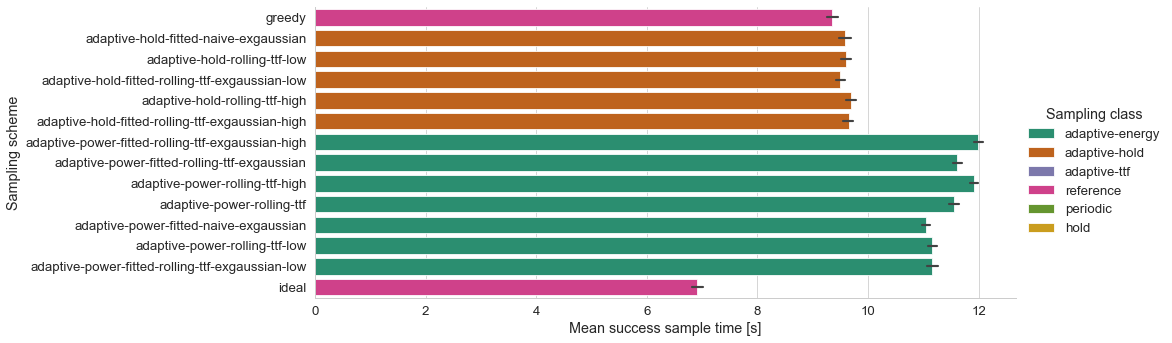

In [21]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="success_sample_instant",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean success sample time [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

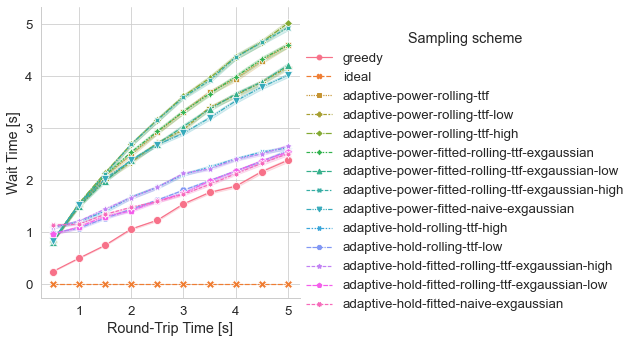

In [23]:
fg = sns.relplot(
    kind="line",
    errorbar=("ci", 95),
    data=results_per_rep,
    x="rtt",
    y="wait_time",
    hue="sampling_scheme",
    style="sampling_scheme",
    markers=True,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Wait Time [s]")
fg.legend.set_title("Sampling scheme")
plt.show()